# Recipe Clustering Analysis

This notebook demonstrates three clustering approaches for grouping recipes based on their sensorik (odor) profiles:

1. **HDBSCAN** - Density-based clustering (allows outliers)
2. **Agglomerative** - Hierarchical clustering (no outliers)
3. **FAISS** - Vector database with k-means (similarity search)

## Key Concept: Weighted Sensorik Importance

Each recipe has up to 16 sensorik descriptors where:
- **Sensorik_1** = Most identifiable odor (weight = 1.0)
- **Sensorik_16** = Least identifiable odor (weight = 0.0625)

## Setup

In [ ]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy scikit-learn hdbscan matplotlib faiss-cpu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import hdbscan
import faiss
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("All packages loaded successfully!")

All packages loaded successfully!


## 1. Load and Explore Data

In [2]:
# Load the data
df = pd.read_csv('../data/gold/Versuchsdaten.csv')

print(f"Total rows: {len(df)}")
print(f"Columns: {len(df.columns)}")
df.head()

Total rows: 840
Columns: 38


,Stamm-Nr.,Rezepturbezeichnung,Ident,Var.,Variantbezeichnung,Vers.,Rez.-Nr.,Ident.1,ERP-Nr.,Name,...,Sensorik_16,Threshold (ppm),Medium,Quelle,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,RE02504_A01,Erdbeer-Aroma,RE02504,A01,"N,AH,UG",5,186.293P,R04571,60030747,"2-Ethyl-4-methylthiazol, nat�rlich",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29200817,Erdbeer-Aroma,RE01424,A01,"N,AH,UG",16,185.796P,R01976,60030429_+K+,"2-Heptanon, nat�rlich Halal",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29201835,Erdbeer-Aroma,RE08030,A01,"N,AH,UG",4,187.746P,R01976,60030429_+K+,"2-Heptanon, nat�rlich Halal",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29202914,Erdbeer-Aroma,RE02292,A05,"N,AF,UG",1,188.796P,R01976,60030429_+K+,"2-Heptanon, nat�rlich Halal",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29200823,Erdbeer-Aroma,RE04338,A01,"A,AF,UG",2,186.950P,R02178,60030571,2-Methyl-2-pentens�ure Halal Kosher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Identify key columns
recipe_col = 'Rez.-Nr.'
sensorik_cols = [f'Sensorik_{i}' for i in range(1, 17)]

print(f"Recipe column: {recipe_col}")
print(f"Unique recipes: {df[recipe_col].nunique()}")
print(f"\nSensorik columns: {sensorik_cols}")

Recipe column: Rez.-Nr.
Unique recipes: 30

Sensorik columns: ['Sensorik_1', 'Sensorik_2', 'Sensorik_3', 'Sensorik_4', 'Sensorik_5', 'Sensorik_6', 'Sensorik_7', 'Sensorik_8', 'Sensorik_9', 'Sensorik_10', 'Sensorik_11', 'Sensorik_12', 'Sensorik_13', 'Sensorik_14', 'Sensorik_15', 'Sensorik_16']


In [4]:
# Explore sensorik values
all_sensorik = []
for col in sensorik_cols:
    vals = df[col].dropna().unique()
    all_sensorik.extend([str(v).lower().strip() for v in vals if pd.notna(v)])

unique_sensorik = sorted(set(all_sensorik))
print(f"Unique sensorik descriptors: {len(unique_sensorik)}")
print(f"\nSample descriptors: {unique_sensorik[:20]}")

Unique sensorik descriptors: 244

Sample descriptors: ['"catty"', '"sherry"', '(cherry-strawberry)', 'acetic', 'acetone-like', 'acid', 'acidic', 'acrid', 'alcohol', 'alcoholic', 'aldehydic', 'almond', 'and', 'anthranilic', 'apple', 'apple-like', 'apple-pear', 'apple-pear-pineapple', 'apricot', 'apricot.']


## 2. Feature Extraction with Weighted Importance

We create weighted feature vectors where:
- Each dimension corresponds to a unique sensorik term
- Weight decreases from Sensorik_1 (1.0) to Sensorik_16 (0.0625)

$$\text{weight}(\text{position}) = \frac{17 - \text{position}}{16}$$

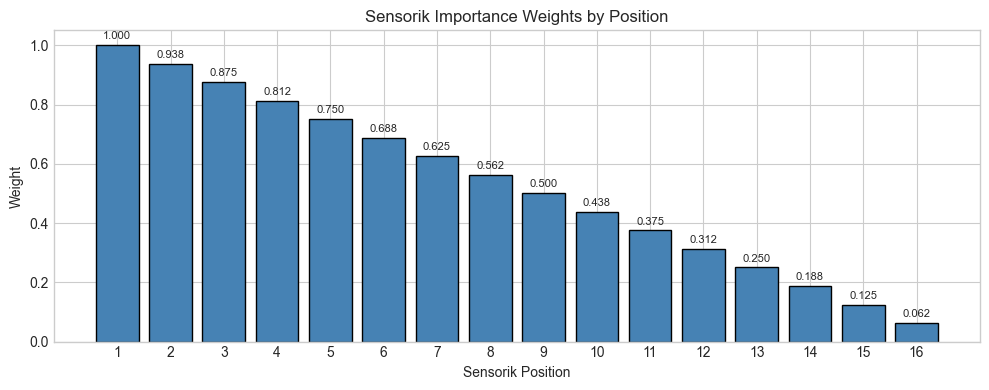

In [5]:
def calculate_weight(position):
    """Calculate importance weight based on sensorik position."""
    return (17 - position) / 16

# Visualize the weight distribution
positions = range(1, 17)
weights = [calculate_weight(p) for p in positions]

plt.figure(figsize=(10, 4))
plt.bar(positions, weights, color='steelblue', edgecolor='black')
plt.xlabel('Sensorik Position')
plt.ylabel('Weight')
plt.title('Sensorik Importance Weights by Position')
plt.xticks(positions)
for i, w in enumerate(weights):
    plt.text(i+1, w+0.02, f'{w:.3f}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

In [6]:
def normalize_term(term):
    """Normalize a sensorik term."""
    if pd.isna(term) or not isinstance(term, str):
        return None
    term = term.lower().strip().replace('"', '').replace("'", "")
    term = term.rstrip('.,;:')
    return term if len(term) >= 2 else None

def build_vocabulary(df, sensorik_cols):
    """Build vocabulary from all sensorik columns."""
    all_terms = set()
    for col in sensorik_cols:
        if col in df.columns:
            terms = df[col].dropna().apply(normalize_term)
            all_terms.update([t for t in terms if t])
    vocabulary = sorted(all_terms)
    vocab_to_idx = {term: idx for idx, term in enumerate(vocabulary)}
    return vocabulary, vocab_to_idx

def extract_recipe_vectors(df, recipe_col, sensorik_cols, vocabulary, vocab_to_idx):
    """Extract weighted feature vectors for each recipe."""
    recipes = df[recipe_col].unique().tolist()
    n_recipes = len(recipes)
    n_features = len(vocabulary)
    
    vectors = np.zeros((n_recipes, n_features))
    
    for recipe_idx, recipe in enumerate(recipes):
        recipe_data = df[df[recipe_col] == recipe]
        
        for _, row in recipe_data.iterrows():
            for position, col in enumerate(sensorik_cols, start=1):
                if col in df.columns:
                    term = normalize_term(row.get(col))
                    if term and term in vocab_to_idx:
                        weight = calculate_weight(position)
                        vectors[recipe_idx, vocab_to_idx[term]] += weight
    
    # L2 normalize
    vectors = normalize(vectors)
    return vectors, recipes

# Build vocabulary and extract vectors
vocabulary, vocab_to_idx = build_vocabulary(df, sensorik_cols)
recipe_vectors, recipes = extract_recipe_vectors(df, recipe_col, sensorik_cols, vocabulary, vocab_to_idx)

print(f"Vocabulary size: {len(vocabulary)}")
print(f"Number of recipes: {len(recipes)}")
print(f"Vector shape: {recipe_vectors.shape}")

Vocabulary size: 242
Number of recipes: 30
Vector shape: (30, 242)


## 3. Helper Functions

In [7]:
def generate_cluster_names(cluster_labels, recipe_vectors, vocabulary, top_n=3):
    """Generate human-readable names for clusters based on distinctive terms."""
    cluster_names = {}
    unique_labels = sorted(set(cluster_labels))
    
    # Calculate global average
    global_centroid = recipe_vectors.mean(axis=0)
    
    for label in unique_labels:
        if label == -1:
            cluster_names[label] = "Outliers"
            continue
        
        cluster_mask = cluster_labels == label
        cluster_vectors = recipe_vectors[cluster_mask]
        centroid = cluster_vectors.mean(axis=0)
        
        # Find distinctive terms
        distinctiveness = centroid - global_centroid * 0.8
        top_indices = np.argsort(distinctiveness)[-6:][::-1]
        
        distinctive_terms = []
        for idx in top_indices:
            if distinctiveness[idx] > 0 and centroid[idx] > 0.05:
                distinctive_terms.append(vocabulary[idx].capitalize())
            if len(distinctive_terms) >= top_n:
                break
        
        if len(distinctive_terms) < 2:
            top_indices = np.argsort(centroid)[-top_n:][::-1]
            distinctive_terms = [vocabulary[i].capitalize() for i in top_indices]
        
        cluster_names[label] = "-".join(distinctive_terms[:top_n])
    
    return cluster_names

def get_cluster_details(cluster_labels, recipe_vectors, recipes, vocabulary, cluster_names):
    """Get detailed information about each cluster."""
    details = {}
    
    for label in sorted(set(cluster_labels)):
        cluster_mask = cluster_labels == label
        cluster_recipes = [recipes[i] for i, m in enumerate(cluster_mask) if m]
        cluster_vectors = recipe_vectors[cluster_mask]
        
        centroid = cluster_vectors.mean(axis=0)
        top_indices = np.argsort(centroid)[-10:][::-1]
        top_terms = [(vocabulary[i], centroid[i]) for i in top_indices]
        
        details[label] = {
            'name': cluster_names.get(label, f"Cluster {label}"),
            'recipes': cluster_recipes,
            'centroid': centroid,
            'top_terms': top_terms,
            'size': len(cluster_recipes)
        }
    
    return details

def print_cluster_summary(details):
    """Print a summary of clusters."""
    for label in sorted(details.keys()):
        info = details[label]
        print(f"\n{'─' * 50}")
        print(f"CLUSTER {label}: {info['name']}")
        print(f"{'─' * 50}")
        print(f"Recipes ({info['size']}): {', '.join(info['recipes'][:5])}{'...' if len(info['recipes']) > 5 else ''}")
        print(f"Top terms:")
        for term, weight in info['top_terms'][:5]:
            bar = '█' * int(weight * 40)
            print(f"  {term:15} {bar} ({weight:.3f})")

In [8]:
def visualize_clusters(recipe_vectors, cluster_labels, cluster_names, recipes, title="Recipe Clusters"):
    """Visualize clusters using t-SNE."""
    # Reduce dimensions with t-SNE
    perplexity = min(5, len(recipes) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=1000)
    coords = tsne.fit_transform(recipe_vectors)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Color palette
    unique_labels = sorted(set(cluster_labels))
    colors = plt.cm.Set2(np.linspace(0, 1, max(len(unique_labels), 8)))
    
    # Plot 1: Scatter plot
    ax1 = axes[0]
    for i, label in enumerate(unique_labels):
        mask = cluster_labels == label
        cluster_coords = coords[mask]
        
        if label == -1:
            color = 'gray'
            marker = 'x'
            alpha = 0.5
        else:
            color = colors[i % len(colors)]
            marker = 'o'
            alpha = 0.8
        
        ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1],
                   c=[color], marker=marker, s=150, alpha=alpha,
                   label=cluster_names.get(label, f"Cluster {label}"),
                   edgecolors='black', linewidths=0.5)
    
    # Add recipe labels
    for i, recipe in enumerate(recipes):
        ax1.annotate(recipe[:10], (coords[i, 0], coords[i, 1]),
                    fontsize=7, alpha=0.7, ha='center', va='bottom')
    
    ax1.set_xlabel('t-SNE Dimension 1')
    ax1.set_ylabel('t-SNE Dimension 2')
    ax1.set_title(f'{title} - t-SNE Visualization')
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cluster sizes
    ax2 = axes[1]
    sizes = [list(cluster_labels).count(l) for l in unique_labels]
    names = [cluster_names.get(l, f"C{l}")[:25] for l in unique_labels]
    bar_colors = [colors[i % len(colors)] if l != -1 else 'gray' for i, l in enumerate(unique_labels)]
    
    bars = ax2.barh(range(len(unique_labels)), sizes, color=bar_colors)
    ax2.set_yticks(range(len(unique_labels)))
    ax2.set_yticklabels(names, fontsize=9)
    ax2.set_xlabel('Number of Recipes')
    ax2.set_title('Cluster Sizes')
    ax2.invert_yaxis()
    
    for bar, size in zip(bars, sizes):
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                str(size), va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return coords

In [9]:
def visualize_radar(details, vocabulary, title="Cluster Sensorik Profiles"):
    """Create radar chart for cluster profiles."""
    # Get top terms across all clusters
    all_top_terms = set()
    for label, info in details.items():
        if label == -1:
            continue
        all_top_terms.update([t[0] for t in info['top_terms'][:8]])
    
    all_top_terms = sorted(all_top_terms)[:12]
    n_terms = len(all_top_terms)
    
    if n_terms == 0:
        print("No data for radar chart")
        return
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    angles = np.linspace(0, 2 * np.pi, n_terms, endpoint=False).tolist()
    angles += angles[:1]
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(details)))
    
    for i, (label, info) in enumerate(details.items()):
        if label == -1:
            continue
        
        term_to_weight = {t[0]: t[1] for t in info['top_terms']}
        values = [term_to_weight.get(term, 0) for term in all_top_terms]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=info['name'],
               color=colors[i % len(colors)])
        ax.fill(angles, values, alpha=0.15, color=colors[i % len(colors)])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(all_top_terms, fontsize=9)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
    
    plt.tight_layout()
    plt.show()

---

# Method 1: HDBSCAN Clustering

HDBSCAN is a density-based clustering algorithm that:
- Automatically determines the number of clusters
- Identifies outliers (recipes that don't fit any cluster)
- Does not force all points into clusters

In [10]:
# Run HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom'
)

hdbscan_labels = hdbscan_clusterer.fit_predict(recipe_vectors)

n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise = list(hdbscan_labels).count(-1)

print("HDBSCAN Results:")
print(f"  Clusters found: {n_clusters}")
print(f"  Outliers: {n_noise} ({n_noise/len(recipes)*100:.1f}%)")

HDBSCAN Results:
  Clusters found: 5
  Outliers: 14 (46.7%)


In [11]:
# Generate cluster names and details
hdbscan_names = generate_cluster_names(hdbscan_labels, recipe_vectors, vocabulary)
hdbscan_details = get_cluster_details(hdbscan_labels, recipe_vectors, recipes, vocabulary, hdbscan_names)

print("Cluster Names:")
for label, name in sorted(hdbscan_names.items()):
    count = list(hdbscan_labels).count(label)
    print(f"  Cluster {label}: {name} ({count} recipes)")

Cluster Names:
  Cluster -1: Outliers (14 recipes)
  Cluster 0: Fruity-Sweet-Waxy (2 recipes)
  Cluster 1: Fruity-Green-Acidic (2 recipes)
  Cluster 2: Fruity-Green-Apple (5 recipes)
  Cluster 3: Green-Sweet-Citrus (5 recipes)
  Cluster 4: Green-Sweet-Waxy (2 recipes)


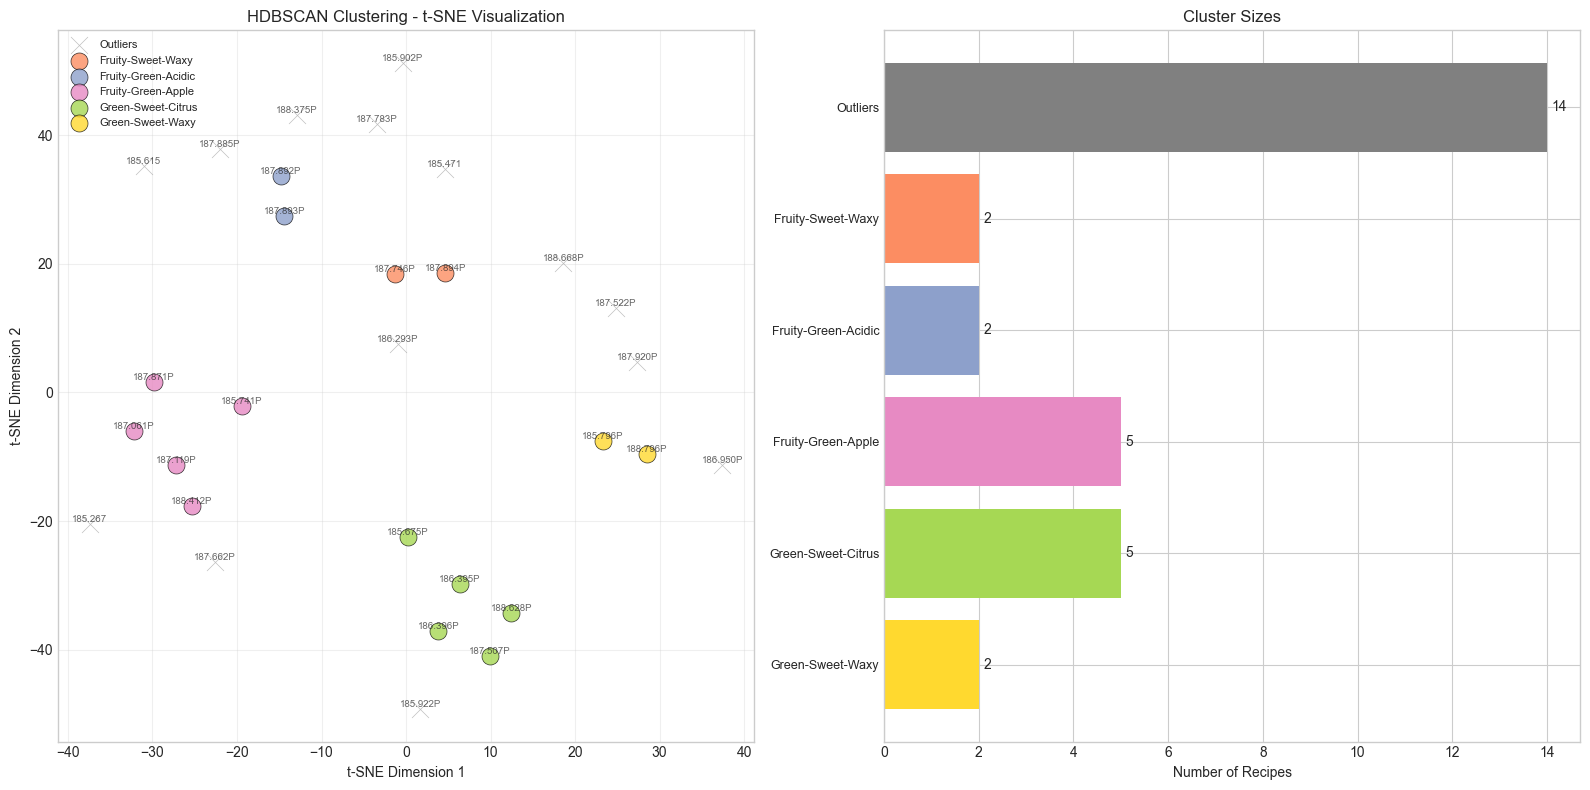

In [12]:
# Visualize HDBSCAN clusters
hdbscan_coords = visualize_clusters(recipe_vectors, hdbscan_labels, hdbscan_names, recipes, 
                                     title="HDBSCAN Clustering")

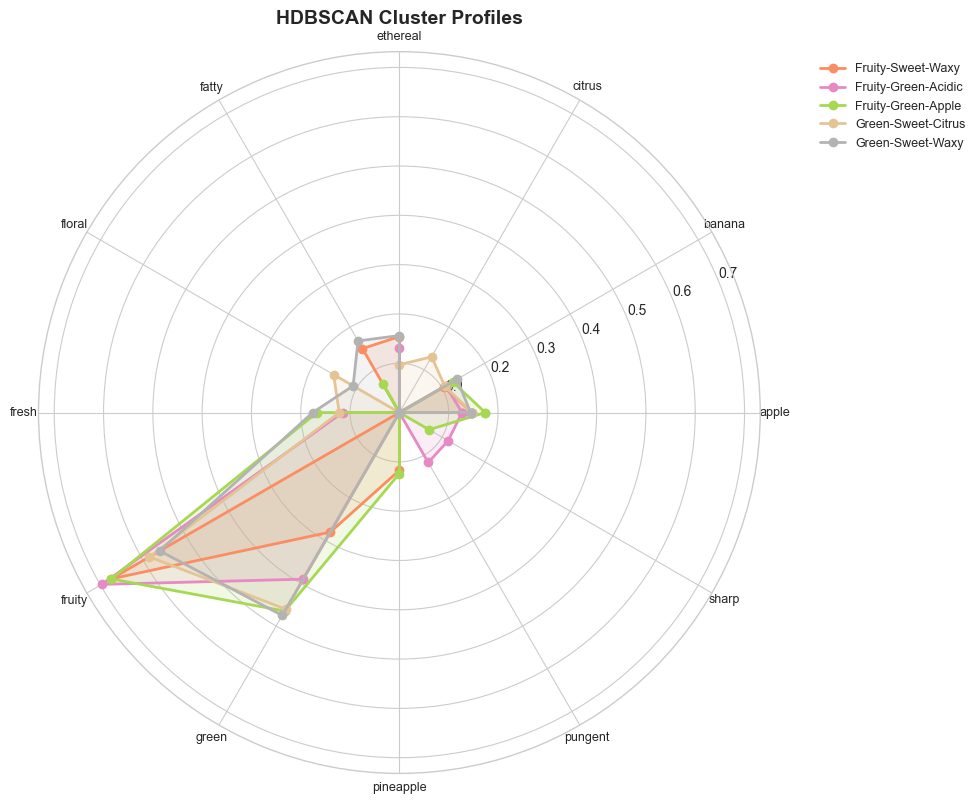

In [13]:
# Radar chart for HDBSCAN
visualize_radar(hdbscan_details, vocabulary, title="HDBSCAN Cluster Profiles")

In [14]:
# Print detailed summary
print_cluster_summary(hdbscan_details)


──────────────────────────────────────────────────
CLUSTER -1: Outliers
──────────────────────────────────────────────────
Recipes (14): 186.293P, 186.950P, 187.885P, 185.615, 187.662P...
Top terms:
  fruity          █████████████████████████ (0.629)
  sweet           ██████████████ (0.368)
  green           █████████████ (0.350)
  fatty           █████ (0.145)
  pineapple       ████ (0.120)

──────────────────────────────────────────────────
CLUSTER 0: Fruity-Sweet-Waxy
──────────────────────────────────────────────────
Recipes (2): 187.746P, 187.894P
Top terms:
  fruity          ██████████████████████████ (0.675)
  sweet           ██████████████████ (0.465)
  green           ███████████ (0.280)
  ethereal        ██████ (0.154)
  fatty           █████ (0.150)

──────────────────────────────────────────────────
CLUSTER 1: Fruity-Green-Acidic
──────────────────────────────────────────────────
Recipes (2): 187.892P, 187.893P
Top terms:
  fruity          ███████████████████████████ (0.69

---

# Method 2: Agglomerative Clustering

Agglomerative Clustering is a hierarchical method that:
- Uses silhouette score to find optimal k
- **Guarantees all recipes are assigned** (no outliers)
- May create singleton clusters for unique recipes

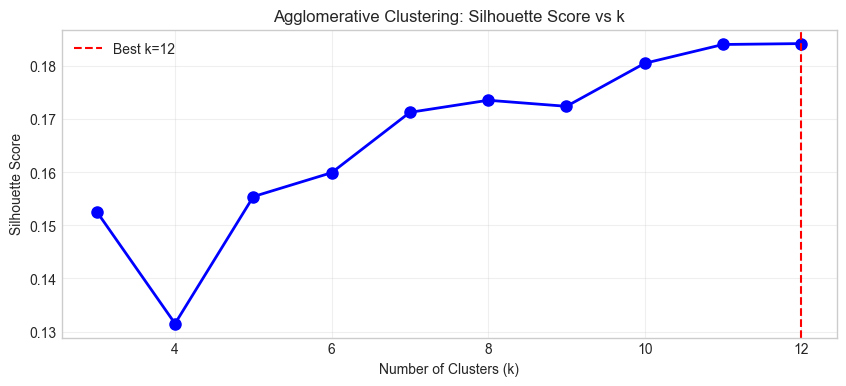

Optimal k: 12 (silhouette score: 0.184)


In [15]:
# Find optimal k using silhouette score
k_range = (3, 12)
silhouette_scores = []

for k in range(k_range[0], min(k_range[1] + 1, len(recipes))):
    agg = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    labels = agg.fit_predict(recipe_vectors)
    score = silhouette_score(recipe_vectors, labels)
    silhouette_scores.append((k, score))

# Plot silhouette scores
ks, scores = zip(*silhouette_scores)
best_k = ks[np.argmax(scores)]
best_score = max(scores)

plt.figure(figsize=(10, 4))
plt.plot(ks, scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative Clustering: Silhouette Score vs k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal k: {best_k} (silhouette score: {best_score:.3f})")

In [16]:
# Run Agglomerative clustering with optimal k
agg_clusterer = AgglomerativeClustering(n_clusters=best_k, metric='euclidean', linkage='ward')
agg_labels = agg_clusterer.fit_predict(recipe_vectors)

print("Agglomerative Clustering Results:")
print(f"  Clusters: {best_k}")
print(f"  Outliers: 0 (all recipes assigned)")
print(f"  Silhouette score: {best_score:.3f}")

Agglomerative Clustering Results:
  Clusters: 12
  Outliers: 0 (all recipes assigned)
  Silhouette score: 0.184


In [17]:
# Generate cluster names and details
agg_names = generate_cluster_names(agg_labels, recipe_vectors, vocabulary)
agg_details = get_cluster_details(agg_labels, recipe_vectors, recipes, vocabulary, agg_names)

print("Cluster Names:")
for label, name in sorted(agg_names.items()):
    count = list(agg_labels).count(label)
    singleton = " (singleton)" if count == 1 else ""
    print(f"  Cluster {label}: {name} ({count} recipes){singleton}")

Cluster Names:
  Cluster 0: Green-Ethereal-Waxy (4 recipes)
  Cluster 1: Fruity-Apple-Floral (2 recipes)
  Cluster 2: Fruity-Sweet-Fatty (3 recipes)
  Cluster 3: Fruity-Acidic-Sharp (5 recipes)
  Cluster 4: Fruity-Green-Apple (6 recipes)
  Cluster 5: Fusel-Oil-Fruit (1 recipes) (singleton)
  Cluster 6: Green-Fresh-Fruit (1 recipes) (singleton)
  Cluster 7: Sweet-Fruity-Pineapple (1 recipes) (singleton)
  Cluster 8: Acidic-Pungent-Fatty (1 recipes) (singleton)
  Cluster 9: Green-Sweet-Citrus (4 recipes)
  Cluster 10: Green-Fresh-Fatty (1 recipes) (singleton)
  Cluster 11: Fruity-Ethereal-Pungent (1 recipes) (singleton)


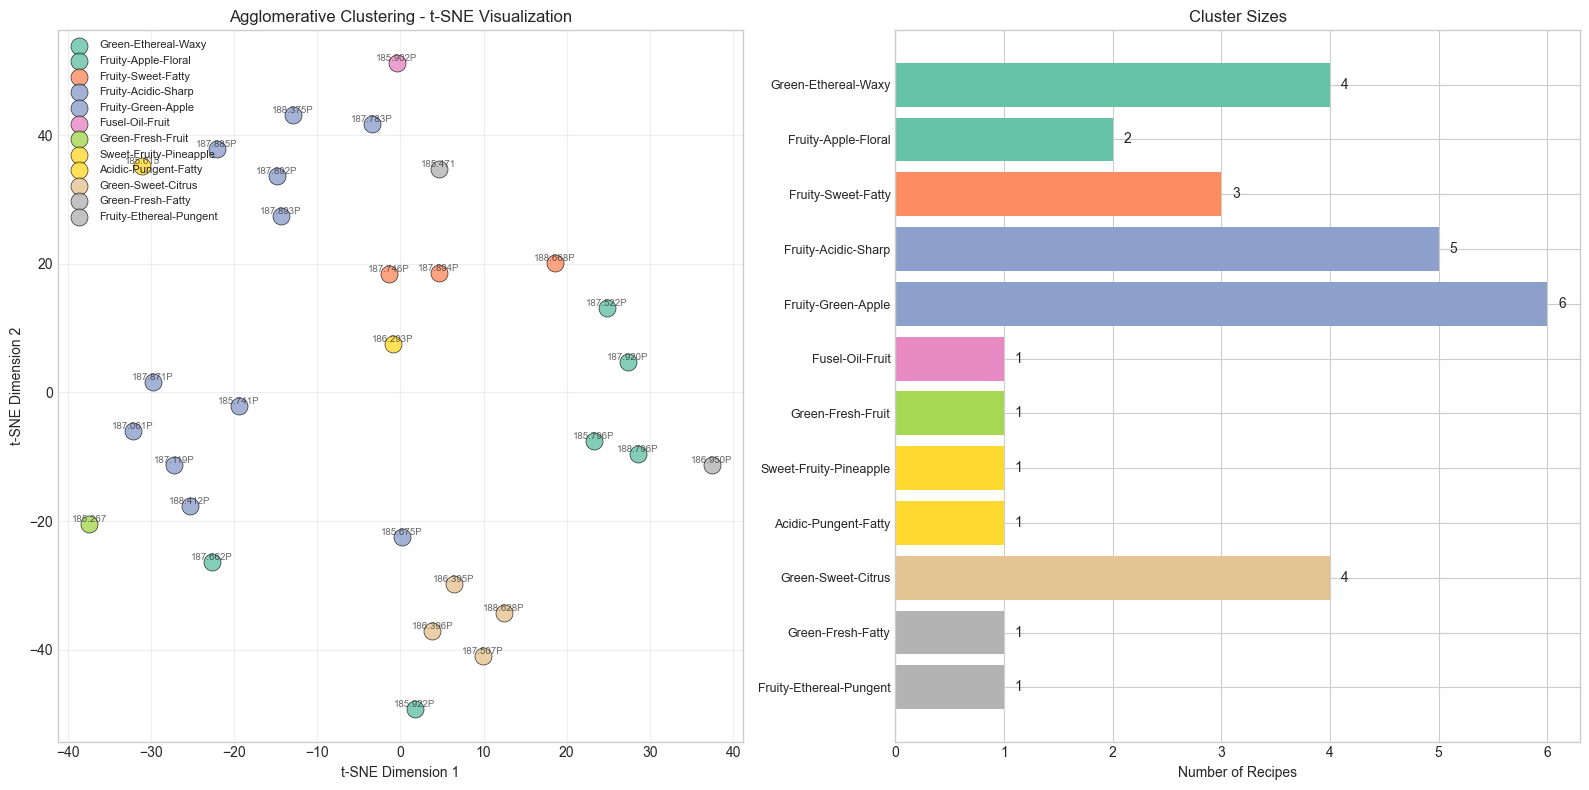

In [18]:
# Visualize Agglomerative clusters
agg_coords = visualize_clusters(recipe_vectors, agg_labels, agg_names, recipes,
                                 title="Agglomerative Clustering")

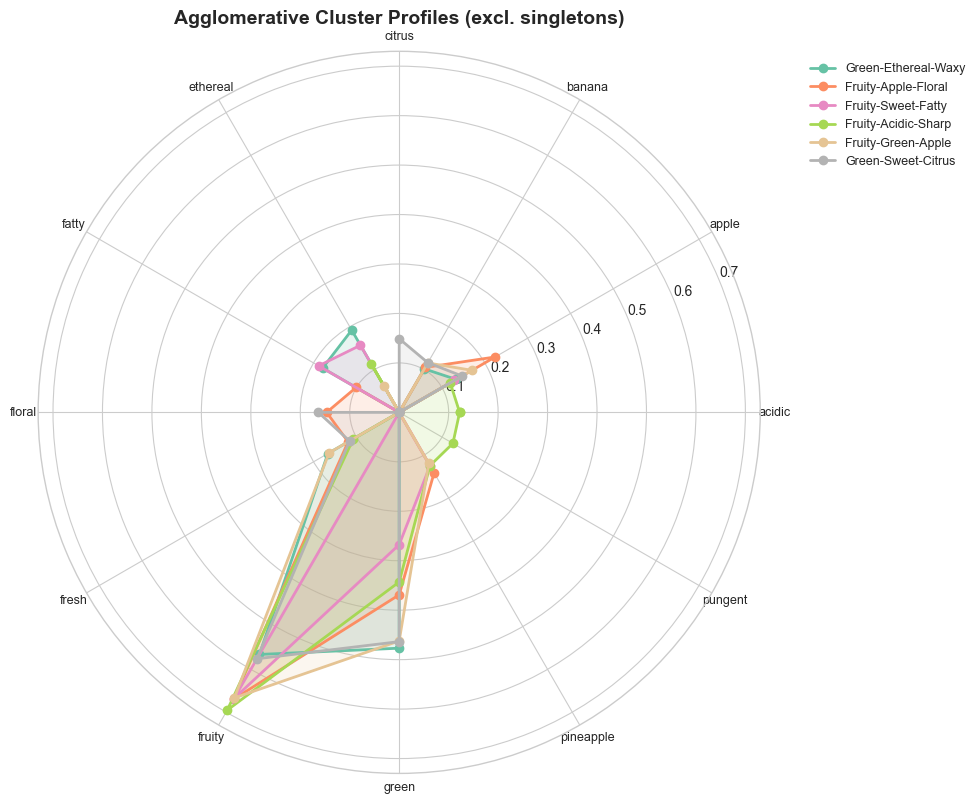

In [19]:
# Radar chart for Agglomerative (excluding singletons for clarity)
agg_details_no_singletons = {k: v for k, v in agg_details.items() if v['size'] > 1}
visualize_radar(agg_details_no_singletons, vocabulary, title="Agglomerative Cluster Profiles (excl. singletons)")

In [20]:
# Print detailed summary
print_cluster_summary(agg_details)


──────────────────────────────────────────────────
CLUSTER 0: Green-Ethereal-Waxy
──────────────────────────────────────────────────
Recipes (4): 185.796P, 188.796P, 187.920P, 187.522P
Top terms:
  fruity          ██████████████████████ (0.565)
  green           ███████████████████ (0.477)
  sweet           ███████████████ (0.385)
  ethereal        ███████ (0.192)
  fatty           ███████ (0.179)

──────────────────────────────────────────────────
CLUSTER 1: Fruity-Apple-Floral
──────────────────────────────────────────────────
Recipes (2): 187.662P, 185.922P
Top terms:
  fruity          ██████████████████████████ (0.670)
  green           ██████████████ (0.369)
  sweet           █████████████ (0.348)
  apple           ████████ (0.224)
  floral          █████ (0.147)

──────────────────────────────────────────────────
CLUSTER 2: Fruity-Sweet-Fatty
──────────────────────────────────────────────────
Recipes (3): 187.746P, 187.894P, 188.668P
Top terms:
  fruity          ████████████████

---

# Method 3: FAISS Vector Database

FAISS provides:
- Efficient k-means clustering
- **Similarity search** capabilities
- Production-ready vector indexing
- Best for recipe creation workflows

In [21]:
# Prepare vectors for FAISS
vectors_float32 = np.ascontiguousarray(recipe_vectors.astype('float32'))
n_samples, d = vectors_float32.shape

# Build FAISS index
faiss_index = faiss.IndexFlatL2(d)
faiss_index.add(vectors_float32)

print(f"FAISS index built:")
print(f"  Vectors: {faiss_index.ntotal}")
print(f"  Dimensions: {d}")

FAISS index built:
  Vectors: 30
  Dimensions: 242


WARNING clustering 30 points to 4 centroids: please provide at least 156 training points
WARNING clustering 30 points to 5 centroids: please provide at least 195 training points
WARNING clustering 30 points to 6 centroids: please provide at least 234 training points
WARNING clustering 30 points to 7 centroids: please provide at least 273 training points
WARNING clustering 30 points to 8 centroids: please provide at least 312 training points
WARNING clustering 30 points to 9 centroids: please provide at least 351 training points
WARNING clustering 30 points to 10 centroids: please provide at least 390 training points
WARNING clustering 30 points to 11 centroids: please provide at least 429 training points
WARNING clustering 30 points to 12 centroids: please provide at least 468 training points


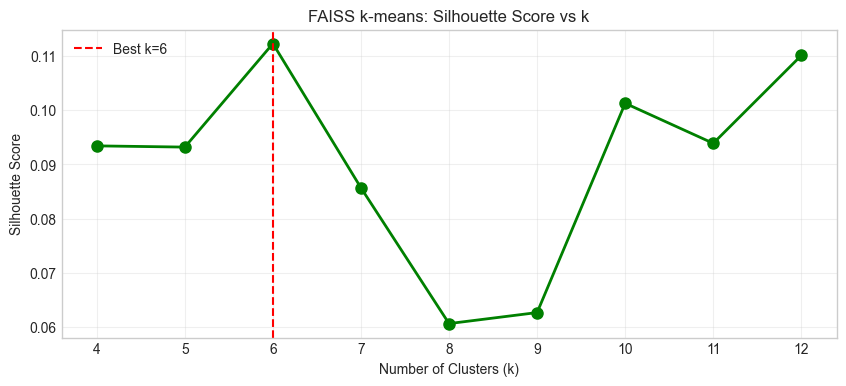

Optimal k: 6 (silhouette score: 0.112)


In [22]:
# Find optimal k using silhouette score with FAISS k-means
k_range = (4, 12)
faiss_scores = []
best_faiss_k = k_range[0]
best_faiss_score = -1
best_centroids = None
best_faiss_labels = None

for k in range(k_range[0], min(k_range[1] + 1, n_samples)):
    kmeans = faiss.Kmeans(d, k, niter=50, verbose=False, seed=42)
    kmeans.train(vectors_float32)
    
    _, labels = kmeans.index.search(vectors_float32, 1)
    labels = labels.flatten()
    
    if len(set(labels)) > 1:
        score = silhouette_score(vectors_float32, labels)
        faiss_scores.append((k, score))
        
        if score > best_faiss_score:
            best_faiss_score = score
            best_faiss_k = k
            best_centroids = kmeans.centroids.copy()
            best_faiss_labels = labels.copy()

# Plot
ks, scores = zip(*faiss_scores)

plt.figure(figsize=(10, 4))
plt.plot(ks, scores, 'go-', linewidth=2, markersize=8)
plt.axvline(x=best_faiss_k, color='r', linestyle='--', label=f'Best k={best_faiss_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('FAISS k-means: Silhouette Score vs k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal k: {best_faiss_k} (silhouette score: {best_faiss_score:.3f})")

In [23]:
# Use the best FAISS labels
faiss_labels = best_faiss_labels

print("FAISS Clustering Results:")
print(f"  Clusters: {best_faiss_k}")
print(f"  Outliers: 0 (all recipes assigned)")
print(f"  Silhouette score: {best_faiss_score:.3f}")

FAISS Clustering Results:
  Clusters: 6
  Outliers: 0 (all recipes assigned)
  Silhouette score: 0.112


In [24]:
# Generate cluster names and details
faiss_names = generate_cluster_names(faiss_labels, recipe_vectors, vocabulary)
faiss_details = get_cluster_details(faiss_labels, recipe_vectors, recipes, vocabulary, faiss_names)

print("Cluster Names:")
for label, name in sorted(faiss_names.items()):
    count = list(faiss_labels).count(label)
    print(f"  Cluster {label}: {name} ({count} recipes)")

Cluster Names:
  Cluster 0: Sweet-Fruity-Tropical (2 recipes)
  Cluster 1: Green-Sweet-Floral (9 recipes)
  Cluster 2: Fruity-Ethereal-Sweet (9 recipes)
  Cluster 3: Fruity-Green-Apple (6 recipes)
  Cluster 4: Acidic-Fruity-Pungent (2 recipes)
  Cluster 5: Fruity-Fusel-Oil (2 recipes)


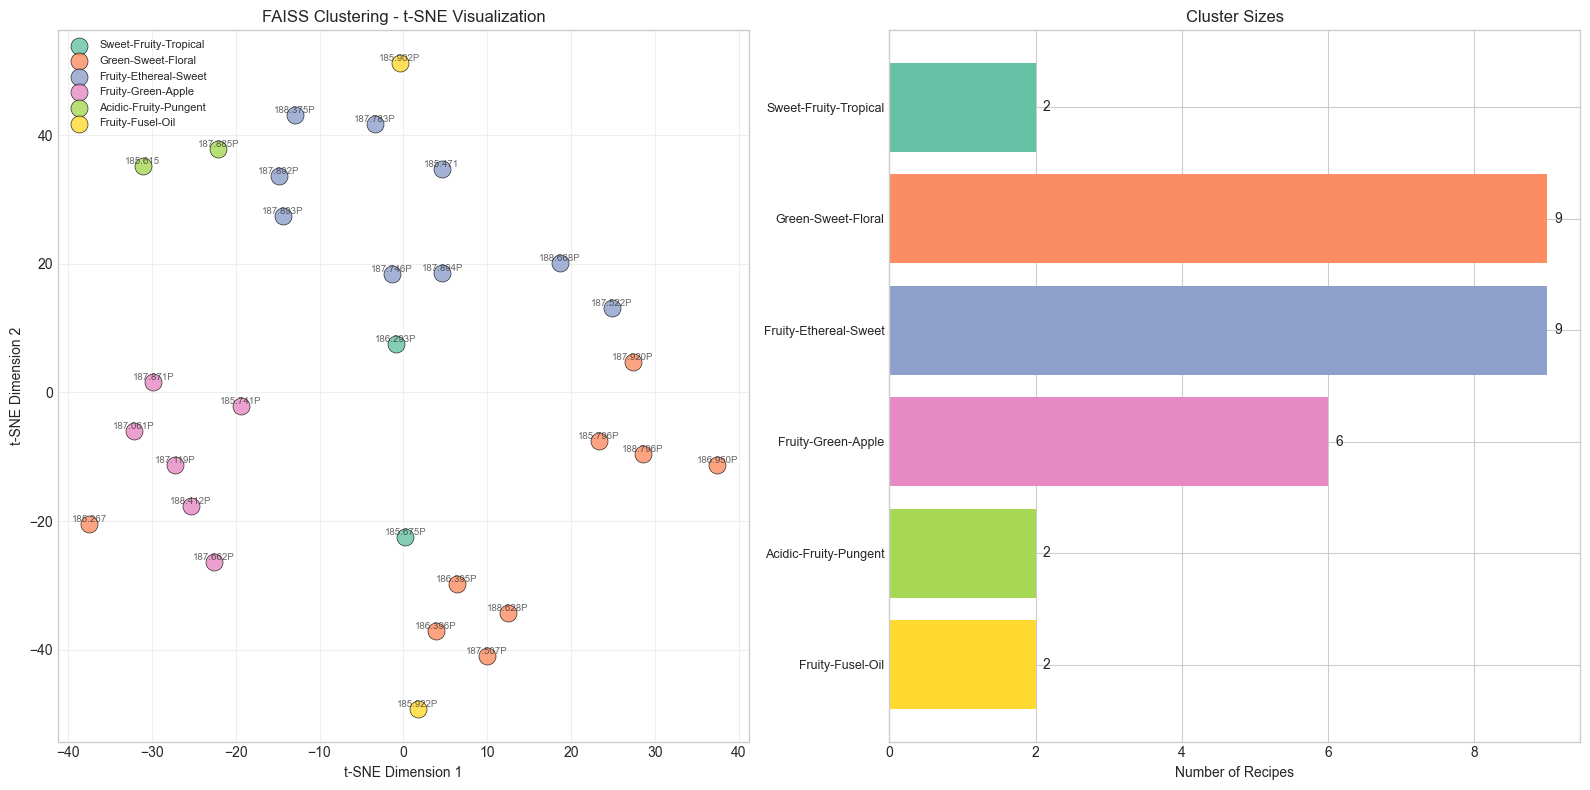

In [25]:
# Visualize FAISS clusters
faiss_coords = visualize_clusters(recipe_vectors, faiss_labels, faiss_names, recipes,
                                   title="FAISS Clustering")

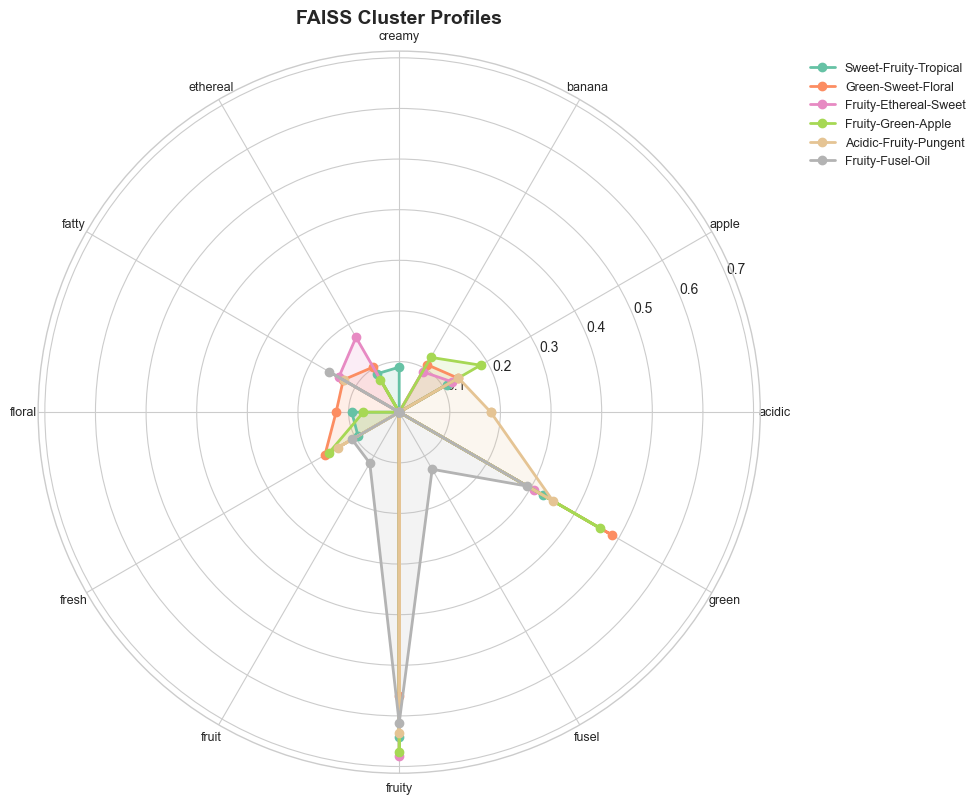

In [26]:
# Radar chart for FAISS
visualize_radar(faiss_details, vocabulary, title="FAISS Cluster Profiles")

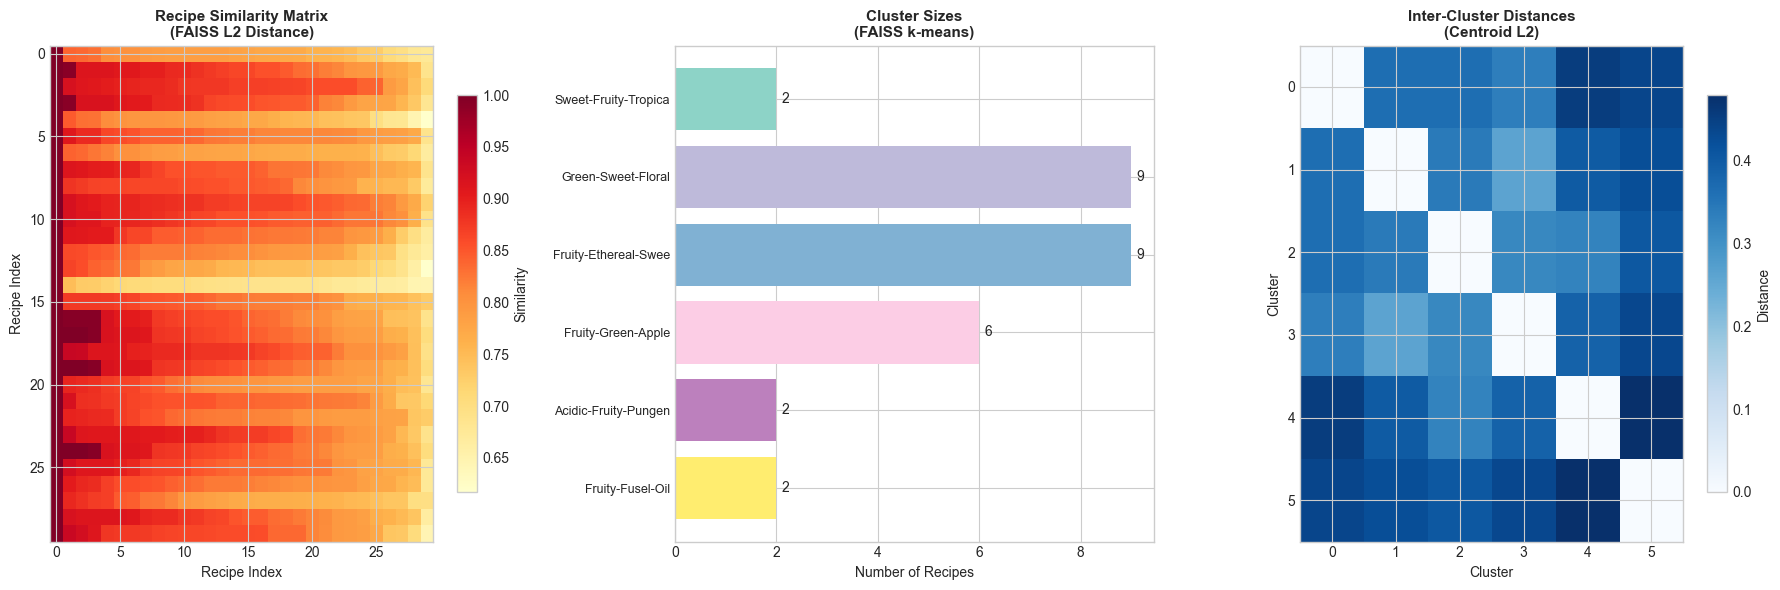

In [27]:
# FAISS-specific: Similarity Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Similarity heatmap
distances, _ = faiss_index.search(vectors_float32, len(recipes))
similarity = 1 / (1 + distances)

im1 = axes[0].imshow(similarity, cmap='YlOrRd', aspect='auto')
axes[0].set_title('Recipe Similarity Matrix\n(FAISS L2 Distance)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Recipe Index')
axes[0].set_ylabel('Recipe Index')
plt.colorbar(im1, ax=axes[0], shrink=0.8, label='Similarity')

# 2. Cluster sizes
unique_labels = sorted(set(faiss_labels))
sizes = [list(faiss_labels).count(l) for l in unique_labels]
names = [faiss_names.get(l, f"C{l}")[:20] for l in unique_labels]
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))

bars = axes[1].barh(range(len(unique_labels)), sizes, color=colors)
axes[1].set_yticks(range(len(unique_labels)))
axes[1].set_yticklabels(names, fontsize=9)
axes[1].set_xlabel('Number of Recipes')
axes[1].set_title('Cluster Sizes\n(FAISS k-means)', fontsize=11, fontweight='bold')
axes[1].invert_yaxis()

for bar, size in zip(bars, sizes):
    axes[1].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, str(size), va='center')

# 3. Inter-cluster distances
n_centroids = len(best_centroids)
centroid_dist = np.zeros((n_centroids, n_centroids))
for i in range(n_centroids):
    for j in range(n_centroids):
        centroid_dist[i, j] = np.linalg.norm(best_centroids[i] - best_centroids[j])

im3 = axes[2].imshow(centroid_dist, cmap='Blues', aspect='auto')
axes[2].set_title('Inter-Cluster Distances\n(Centroid L2)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Cluster')
plt.colorbar(im3, ax=axes[2], shrink=0.8, label='Distance')

plt.tight_layout()
plt.show()

In [28]:
# Print detailed summary
print_cluster_summary(faiss_details)


──────────────────────────────────────────────────
CLUSTER 0: Sweet-Fruity-Tropical
──────────────────────────────────────────────────
Recipes (2): 186.293P, 185.675P
Top terms:
  fruity          █████████████████████████ (0.643)
  sweet           ████████████████████ (0.508)
  green           █████████████ (0.328)
  pineapple       █████ (0.136)
  apple           ████ (0.109)

──────────────────────────────────────────────────
CLUSTER 1: Green-Sweet-Floral
──────────────────────────────────────────────────
Recipes (9): 185.796P, 188.796P, 186.950P, 187.920P, 185.267...
Top terms:
  fruity          ██████████████████████ (0.561)
  green           ███████████████████ (0.485)
  sweet           ████████████████ (0.406)
  fresh           ██████ (0.170)
  apple           █████ (0.134)

──────────────────────────────────────────────────
CLUSTER 2: Fruity-Ethereal-Sweet
──────────────────────────────────────────────────
Recipes (9): 187.746P, 187.892P, 187.893P, 185.471, 187.783P...
Top term

## FAISS Similarity Search Demo

In [29]:
def find_similar_recipes(recipe_idx, top_k=5):
    """Find most similar recipes using FAISS."""
    query = vectors_float32[recipe_idx:recipe_idx+1]
    distances, indices = faiss_index.search(query, top_k + 1)
    
    results = []
    for dist, idx in zip(distances[0], indices[0]):
        if idx != recipe_idx:
            results.append((recipes[idx], float(dist)))
    return results[:top_k]

# Demo: Find similar recipes
print("FAISS Similarity Search Demo")
print("=" * 50)

for i in [0, 15, 29]:
    recipe = recipes[i]
    similar = find_similar_recipes(i, top_k=3)
    print(f"\nRecipes similar to '{recipe}':")
    for sim_recipe, dist in similar:
        print(f"  • {sim_recipe} (distance: {dist:.4f})")

FAISS Similarity Search Demo

Recipes similar to '186.293P':
  • 187.746P (distance: 0.1922)
  • 187.894P (distance: 0.1963)
  • 185.675P (distance: 0.2052)

Recipes similar to '185.922P':
  • 186.396P (distance: 0.1434)
  • 187.507P (distance: 0.1434)
  • 188.628P (distance: 0.1434)

Recipes similar to '187.061P':
  • 187.119P (distance: 0.0677)
  • 187.871P (distance: 0.0819)
  • 188.412P (distance: 0.0968)


In [30]:
def find_recipes_by_profile(target_profile, top_k=5):
    """Find recipes matching a target sensorik profile."""
    query = np.zeros((1, len(vocabulary)), dtype='float32')
    for term, weight in target_profile.items():
        term_normalized = term.lower().strip()
        if term_normalized in vocab_to_idx:
            query[0, vocab_to_idx[term_normalized]] = weight
    
    query = normalize(query).astype('float32')
    distances, indices = faiss_index.search(query, top_k)
    
    return [(recipes[idx], float(dist)) for dist, idx in zip(distances[0], indices[0])]

# Demo: Search by custom profile
print("\nCustom Profile Search")
print("=" * 50)

custom_profile = {
    'fruity': 0.8,
    'sweet': 0.6,
    'tropical': 0.4,
    'pineapple': 0.3
}

print("\nSearching for recipes matching:")
for term, weight in custom_profile.items():
    print(f"  {term}: {weight}")

matches = find_recipes_by_profile(custom_profile, top_k=5)
print("\nBest matching recipes:")
for recipe, dist in matches:
    print(f"  • {recipe} (distance: {dist:.4f})")


Custom Profile Search

Searching for recipes matching:
  fruity: 0.8
  sweet: 0.6
  tropical: 0.4
  pineapple: 0.3

Best matching recipes:
  • 186.293P (distance: 0.2968)
  • 187.746P (distance: 0.4332)
  • 185.471 (distance: 0.4459)
  • 185.922P (distance: 0.4801)
  • 187.894P (distance: 0.4831)


---

# Comparison of All Methods

In [31]:
# Create comparison table
comparison_data = {
    'Metric': [
        'Clusters Found',
        'Outliers',
        'Singletons',
        'Silhouette Score',
        'Similarity Search',
        'Auto k Selection',
        'Largest Cluster',
        'Smallest Cluster'
    ],
    'HDBSCAN': [
        len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0),
        f"{list(hdbscan_labels).count(-1)} ({list(hdbscan_labels).count(-1)/len(recipes)*100:.0f}%)",
        sum(1 for l in set(hdbscan_labels) if l != -1 and list(hdbscan_labels).count(l) == 1),
        'N/A',
        'No',
        'Yes',
        max(list(hdbscan_labels).count(l) for l in set(hdbscan_labels) if l != -1) if any(l != -1 for l in hdbscan_labels) else 0,
        min(list(hdbscan_labels).count(l) for l in set(hdbscan_labels) if l != -1) if any(l != -1 for l in hdbscan_labels) else 0
    ],
    'Agglomerative': [
        len(set(agg_labels)),
        '0 (0%)',
        sum(1 for l in set(agg_labels) if list(agg_labels).count(l) == 1),
        f'{best_score:.3f}',
        'No',
        'Yes',
        max(list(agg_labels).count(l) for l in set(agg_labels)),
        min(list(agg_labels).count(l) for l in set(agg_labels))
    ],
    'FAISS': [
        len(set(faiss_labels)),
        '0 (0%)',
        sum(1 for l in set(faiss_labels) if list(faiss_labels).count(l) == 1),
        f'{best_faiss_score:.3f}',
        'Yes',
        'Yes',
        max(list(faiss_labels).count(l) for l in set(faiss_labels)),
        min(list(faiss_labels).count(l) for l in set(faiss_labels))
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Metric', inplace=True)

print("\n" + "=" * 70)
print("COMPARISON TABLE: All Clustering Methods")
print("=" * 70)
print(comparison_df.to_string())


COMPARISON TABLE: All Clustering Methods
                    HDBSCAN Agglomerative   FAISS
Metric                                           
Clusters Found            5            12       6
Outliers           14 (47%)        0 (0%)  0 (0%)
Singletons                0             6       0
Silhouette Score        N/A         0.184   0.112
Similarity Search        No            No     Yes
Auto k Selection        Yes           Yes     Yes
Largest Cluster           5             6       9
Smallest Cluster          2             1       2


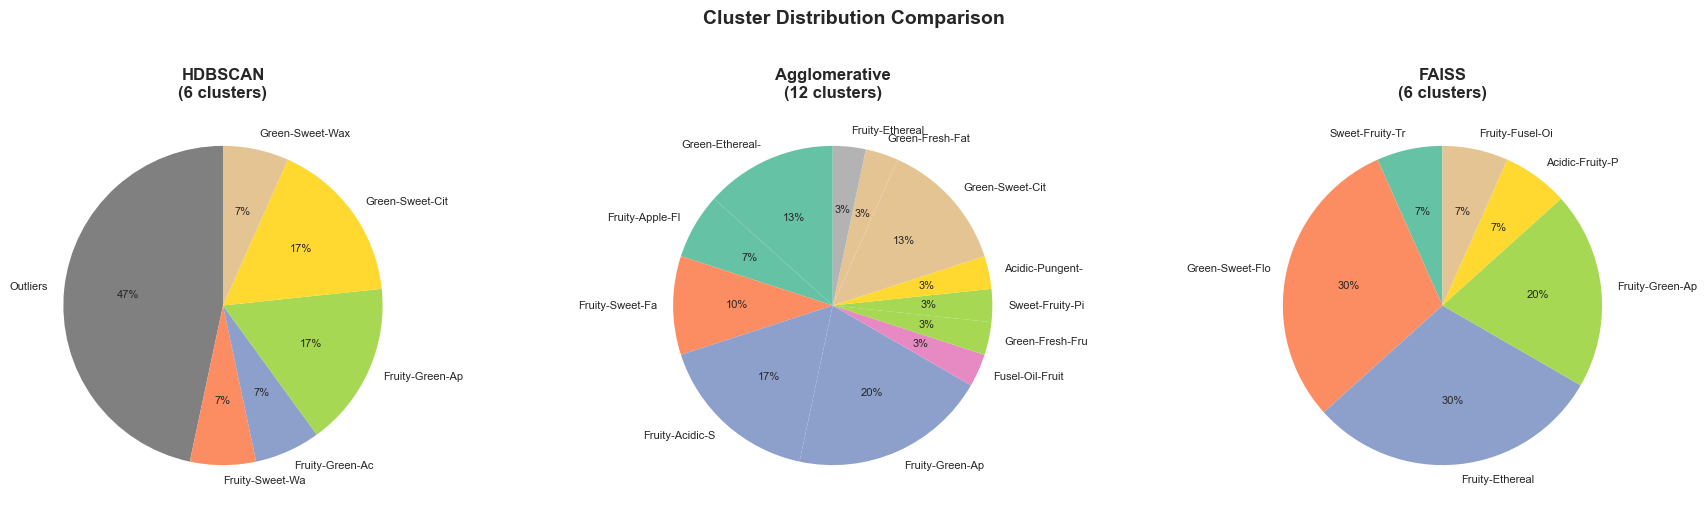

In [32]:
# Visual comparison of cluster distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    ('HDBSCAN', hdbscan_labels, hdbscan_names),
    ('Agglomerative', agg_labels, agg_names),
    ('FAISS', faiss_labels, faiss_names)
]

for ax, (method_name, labels, names) in zip(axes, methods):
    unique_labels = sorted(set(labels))
    sizes = [list(labels).count(l) for l in unique_labels]
    label_names = [names.get(l, f"C{l}")[:15] for l in unique_labels]
    colors = ['gray' if l == -1 else plt.cm.Set2(i/len(unique_labels)) 
              for i, l in enumerate(unique_labels)]
    
    ax.pie(sizes, labels=label_names, colors=colors, autopct='%1.0f%%',
           startangle=90, textprops={'fontsize': 8})
    ax.set_title(f'{method_name}\n({len(unique_labels)} clusters)', fontsize=12, fontweight='bold')

plt.suptitle('Cluster Distribution Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# Creating New Recipes

All methods support creating new recipe profiles by averaging cluster centroids.

In [33]:
def create_new_recipe_profile(cluster_labels, recipe_vectors, vocabulary, cluster_weights):
    """Create a new recipe profile by weighted averaging of cluster centroids."""
    total_weight = sum(cluster_weights.values())
    normalized_weights = {k: v/total_weight for k, v in cluster_weights.items()}
    
    new_profile = np.zeros(len(vocabulary))
    
    for label, weight in normalized_weights.items():
        if label == -1:
            continue
        cluster_mask = cluster_labels == label
        cluster_vectors = recipe_vectors[cluster_mask]
        centroid = cluster_vectors.mean(axis=0)
        new_profile += weight * centroid
    
    top_indices = np.argsort(new_profile)[-15:][::-1]
    top_terms = [(vocabulary[i], new_profile[i]) for i in top_indices]
    
    return new_profile, top_terms

# Demo: Create new recipe using FAISS clusters
print("Creating New Recipe Profile")
print("=" * 50)

# Mix two clusters
cluster_a = 0
cluster_b = 1

print(f"\nMixing:")
print(f"  70% Cluster {cluster_a} ({faiss_names.get(cluster_a, 'Unknown')})")
print(f"  30% Cluster {cluster_b} ({faiss_names.get(cluster_b, 'Unknown')})")

profile, top_terms = create_new_recipe_profile(
    faiss_labels, recipe_vectors, vocabulary,
    {cluster_a: 0.7, cluster_b: 0.3}
)

print(f"\nNew Recipe Target Sensorik Profile:")
for term, weight in top_terms[:10]:
    bar = '█' * int(weight * 50)
    print(f"  {term:15} {bar} ({weight:.3f})")

Creating New Recipe Profile

Mixing:
  70% Cluster 0 (Sweet-Fruity-Tropical)
  30% Cluster 1 (Green-Sweet-Floral)

New Recipe Target Sensorik Profile:
  fruity          ██████████████████████████████ (0.618)
  sweet           ███████████████████████ (0.478)
  green           ██████████████████ (0.375)
  pineapple       █████ (0.119)
  fresh           █████ (0.117)
  apple           █████ (0.116)
  floral          █████ (0.103)
  ethereal        ████ (0.092)
  creamy          ████ (0.081)
  fatty           ███ (0.075)


In [34]:
# Find similar existing recipes for the new profile
query = normalize(profile.reshape(1, -1)).astype('float32')
distances, indices = faiss_index.search(query, 5)

print("\nMost Similar Existing Recipes:")
for dist, idx in zip(distances[0], indices[0]):
    print(f"  • {recipes[idx]} (distance: {dist:.4f})")


Most Similar Existing Recipes:
  • 185.675P (distance: 0.0341)
  • 186.396P (distance: 0.0764)
  • 187.507P (distance: 0.0764)
  • 188.628P (distance: 0.0764)
  • 186.395P (distance: 0.0774)


---

# Summary

## When to Use Each Method

| Method | Best For |
|--------|----------|
| **HDBSCAN** | Identifying unique/outlier recipes, data exploration |
| **Agglomerative** | Fine-grained categorization, hierarchical relationships |
| **FAISS** | Recipe creation, similarity search, production systems |

## Key Takeaways

1. **Weighted importance** is preserved in all methods through feature extraction
2. **HDBSCAN** found 47% outliers - useful for identifying truly unique recipes
3. **Agglomerative** created fine-grained clusters with 6 singletons
4. **FAISS** provides the best balance + similarity search for recipe creation